In [1]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from spectpsftoolbox.simind_io import get_projections, get_source_detector_distances
from spectpsftoolbox.operator2d import GaussianOperator, Kernel2DOperator
from spectpsftoolbox.kernel2d import NGonKernel2D
from spectpsftoolbox.simind_io import get_projections, get_source_detector_distances
import pytomography
from pytomography.io.SPECT import simind
from pytomography.io.SPECT.shared import subsample_projections_and_modify_metadata, subsample_amap
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEM
from pytomography.likelihoods import PoissonLogLikelihood
device = pytomography.device


          -  -  -  -  -  -  -  -   -  -  -  -
          P  A  R  A  L  L  E  L | P  R  O  J
          -  -  -  -  -  -  -  -   -  -  -  -


         Please consider citing our publication
      ---------------------------------------------
      Georg Schramm and Kris Thielemans:
      "PARALLELPROJ—an open-source framework for
       fast calculation of projections in
       tomography"
      Front. Nucl. Med., 08 January 2024
      Sec. PET and SPECT, Vol 3
      https://doi.org/10.3389/fnume.2023.1324562

 
    parallelproj C    lib: /data/anaconda/envs/pytomo_install_test/lib/libparallelproj_c.so.1.8.0
    parallelproj CUDA lib: /data/anaconda/envs/pytomo_install_test/lib/libparallelproj_cuda.so.1.8.0
    


In [2]:
headerpaths = np.array([f'/disk1/psf_data/208keV_ME_PSF/point_position{i}_tot_w1.h00' for i in range(538,1638)])
respaths = np.array([f'/disk1/psf_data/208keV_ME_PSF/point_position{i}.res' for i in range(538,1638)])
distances_all = get_source_detector_distances(respaths).to(device)
projectionss_data = get_projections(headerpaths).to(device)[:,1:,1:]
projectionss_data_norm = get_projections(headerpaths).to(device).sum(dim=(1,2)).mean()

distances = torch.tensor([1,5,10,15,20,25,30,35,40,45,50,55.]).to(device)
differences = torch.abs(distances[:, None] - distances_all)
indices = list(torch.argmin(differences, dim=1).cpu())
headerpaths = headerpaths[indices]
respaths = respaths[indices]
distances = get_source_detector_distances(respaths).to(device)
projectionss_data = get_projections(headerpaths).to(device)[:,1:,1:] / projectionss_data_norm
a_min = torch.min(distances).item()
a_max = torch.max(distances).item()

In [3]:
Nx0 = 127
dx0 = 0.48
x_eval = y_eval = torch.arange(-(Nx0-1)/2, (Nx0+1)/2, 1).to(device) * dx0
xv, yv = torch.meshgrid(torch.tensor(x_eval).to(device).to(torch.float32), torch.tensor(y_eval).to(device).to(torch.float32), indexing='xy')

/tmp/ipykernel_5858/3805311267.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xv, yv = torch.meshgrid(torch.tensor(x_eval).to(device).to(torch.float32), torch.tensor(y_eval).to(device).to(torch.float32), indexing='xy')


Model the geometric component of the scintillator response (dominant for medium energy collimators):

In [4]:
Lb = 4.060 # cm length of collimator
mu = 17.31149149658225
sigma_fn = lambda a, bs: (bs[0]+a) / bs[0] 
amplitude_fn = lambda a, bs: torch.ones_like(a)
sigma_params = torch.tensor([Lb-2/mu], requires_grad=True, dtype=torch.float32, device=device)
amplitude_params = torch.tensor([1.], requires_grad=True, dtype=torch.float32, device=device)
ngon_kernel = NGonKernel2D(
    N_sides = 6,
    Nx = 255,
    collimator_width=0.294,
    amplitude_fn=amplitude_fn,
    sigma_fn=sigma_fn,
    amplitude_params=amplitude_params,
    sigma_params=sigma_params,
    rot=90
)

ngon_operator = Kernel2DOperator(ngon_kernel, use_fft_conv=False)

In [5]:
intrinsic_sigma = 0.3117568/(2*np.sqrt(2*np.log(2)))
gauss_amplitude_fn = lambda a, bs: torch.ones_like(a)
gauss_sigma_fn = lambda a, bs: bs[0]*torch.ones_like(a)
gauss_amplitude_params = torch.tensor([1.], requires_grad=True, dtype=torch.float32, device=device)
gauss_sigma_params = torch.tensor([intrinsic_sigma], requires_grad=True, device=device, dtype=torch.float32)
gaussian_operator = GaussianOperator(
    gauss_amplitude_fn,
    gauss_sigma_fn,
    gauss_amplitude_params,
    gauss_sigma_params,
)

/data/anaconda/envs/pytomo_install_test/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/data/anaconda/envs/pytomo_install_test/lib/python3.11/site-packages/torchquad/integration/utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


In [6]:
psf_operator = gaussian_operator * ngon_operator

Optimize the PSF operator, like was done in tutorial 3

In [7]:
input = torch.zeros((12,127,127)).to(device)
input[:,63,63] = 1

def loss_fn(psf_pred, psf_data):
    return torch.sum((psf_pred - psf_data)**2)  

def train_w(operator, n_iters, lr=1e-3):
    optimizer = optim.Adam([*operator.params], lr=lr)
    for _ in range(n_iters):
        optimizer.zero_grad()
        error = loss_fn(operator(input,xv,yv,distances,normalize=True),projectionss_data)
        print(error.item(), end="\r")
        error.backward()
        optimizer.step()
        
train_w(psf_operator, n_iters=400, lr=4e-3)

Lets look at the results:

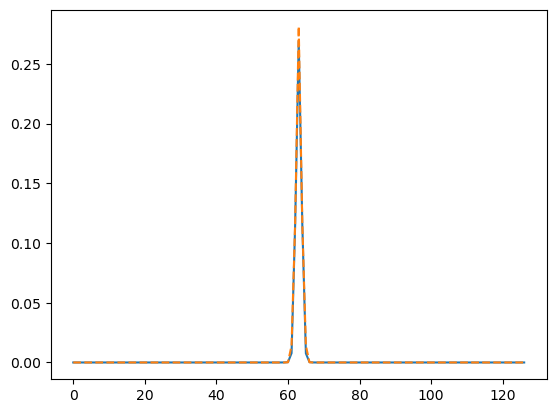

In [8]:
output_tot = psf_operator(input, xv, yv, distances, normalize=True)
IDX = 1
plt.plot(projectionss_data[IDX,63].cpu())
plt.plot(output_tot[IDX,63].detach().cpu(), ls='--')

In [9]:
psf_operator.save('/disk1/psf_data/operators/lu177_ME_GC.pkl')

## Part 2: Reconstruction

Now we'll compare standard Gaussian PSF modeling the PSF model obtained here

* Open SIMIND data:

In [13]:
activity = 1000 # MBq
dT = 15 # seconds per projection

paths = [f'/disk1/psf_data/208keV_ME_jaszak/tot_w{i}.h00' for i in range(1,4)]
object_meta, proj_meta = simind.get_metadata(paths[0])
projections = simind.get_projections(paths)
projections = torch.poisson(activity*dT*projections)

object_meta, proj_meta, projections = subsample_projections_and_modify_metadata(object_meta, proj_meta, projections, N_pixel = 2, N_angle=1)
photopeak = projections[1]
ww_peak = simind.get_energy_window_width(paths[1])
ww_lower = simind.get_energy_window_width(paths[0])
ww_upper = simind.get_energy_window_width(paths[2])
lower_scatter = projections[0]
upper_scatter = projections[2]
scatter = (lower_scatter/ww_lower+upper_scatter/ww_upper)*ww_peak/2
attenuation_path = '/disk1/psf_data/208keV_ME_jaszak/amap.hct'
attenuation_map = simind.get_attenuation_map(attenuation_path)
attenuation_map = subsample_amap(attenuation_map, 2)
att_transform = SPECTAttenuationTransform(attenuation_map)

* Reconstruct

In [14]:
def reconstruct(psf_operator = None):
    if psf_operator is None:
        psf_meta = simind.get_psfmeta_from_header(paths[0])
        psf_transform = SPECTPSFTransform(psf_meta)
    else:
        psf_transform = SPECTPSFTransform(psf_operator=psf_operator)
    system_matrix = SPECTSystemMatrix(
        obj2obj_transforms = [att_transform,psf_transform],
        proj2proj_transforms = [],
        object_meta = object_meta,
        proj_meta = proj_meta
        )
    likelihood = PoissonLogLikelihood(system_matrix, photopeak, additive_term=scatter)
    recon_algorithm = OSEM(likelihood)
    return recon_algorithm(n_iters = 4, n_subsets = 8)

In [15]:
recon_gaussian_psf = reconstruct()
recon_ngon_psf = reconstruct(psf_operator)

Lets look at the difference for using the ngon PSF:

(34.0, 94.0, 34.0, 94.0)

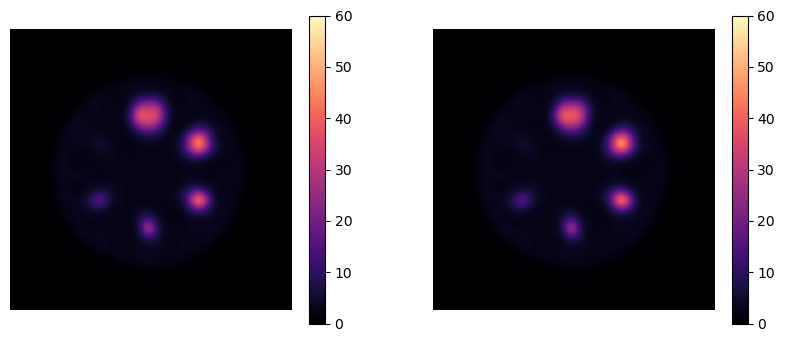

In [16]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(recon_gaussian_psf[:,:,64].cpu().T, cmap='magma', interpolation='gaussian', vmax=60)
plt.xlim(64-30, 64+30)
plt.ylim(64-30, 64+30)
plt.colorbar()
plt.axis('off')
plt.subplot(122)
plt.imshow(recon_ngon_psf[:,:,64].cpu().T, cmap='magma', interpolation='gaussian', vmax=60)
plt.xlim(64-30, 64+30)
plt.ylim(64-30, 64+30)
plt.colorbar()
plt.axis('off')

Text(0, 0.5, 'Counts')

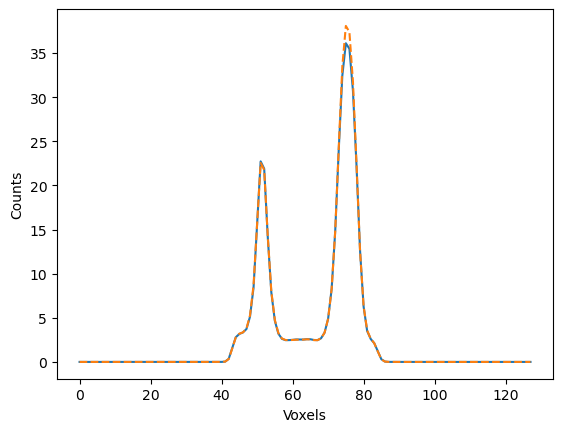

In [18]:
IDX = 0
plt.plot(recon_gaussian_psf[64,:,64].cpu())
plt.plot(recon_ngon_psf[64,:,64].detach().cpu(), ls='--')
plt.xlabel('Voxels')
plt.ylabel('Counts')

Note that the peak value is slightly larger in the larger sphere. More comprehensive studies might seek to study the impact on recovery coefficients.